In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pickle

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#### The Medley Instruments Data Set

In [3]:
df = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata.csv')

In [4]:
df

,subset,instrument,instrument_id,song_id,uuid4
0,test,clarinet,0,0,0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3
1,test,clarinet,0,0,33383119-fd64-59c1-f596-d1a23e8a0eff
2,test,clarinet,0,0,b2b7a288-e169-5642-fced-b509c06b11fc
3,test,clarinet,0,0,151b6ee4-313a-58d9-fbcb-bab73e0d426b
4,test,clarinet,0,0,b43999d1-9b5e-557f-f9bc-1b3759659858
...,...,...,...,...,...
21566,validation,violin,7,226,fe4e8e98-6e0f-5a31-f446-99c10e0ac485
21567,validation,violin,7,226,aa606c78-9ee5-507f-f7e9-67c3530faf0f
21568,validation,violin,7,226,05e15c0a-d530-5f3e-fa82-58c55fa44993
21569,validation,violin,7,226,2dd485de-471d-5d8b-fe92-ef957dac021c


In [5]:
df.nunique()

subset               3
instrument           8
instrument_id        8
song_id            227
uuid4            21571
dtype: int64

In [6]:
df['instrument'].unique()

array(['clarinet', 'distorted electric guitar', 'female singer', 'flute',
       'piano', 'tenor saxophone', 'trumpet', 'violin'], dtype=object)

In [7]:
df.groupby(['instrument']).count()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1311,1311,1311,1311
distorted electric guitar,1854,1854,1854,1854
female singer,1744,1744,1744,1744
flute,3555,3555,3555,3555
piano,6032,6032,6032,6032
tenor saxophone,477,477,477,477
trumpet,627,627,627,627
violin,5971,5971,5971,5971


In [8]:
df.groupby(['instrument']).count().sum()

subset           21571
instrument_id    21571
song_id          21571
uuid4            21571
dtype: int64

In [9]:
df['subset'].unique()

array(['test', 'training', 'validation'], dtype=object)

In [10]:
df.groupby(['subset']).count()

,instrument,instrument_id,song_id,uuid4
subset,,,,
test,12236,12236,12236,12236
training,5841,5841,5841,5841
validation,3494,3494,3494,3494


Splitting Dataframe into Train, Validation and Test Dataframes

In [11]:
df_train = df.loc[df['subset']=='training']

##### Read train, validation and test dataframes

In [12]:
df_train = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_training.csv',index_col=0)

In [13]:
df_val = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_validation.csv',index_col=0)

In [14]:
df_test = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_test.csv',index_col=0)

In [15]:
df_train.head()

,subset,instrument,instrument_id,song_id,uuid4
12236,training,clarinet,0,139,163fd2b1-8e98-515a-f501-4742cc6d066f
12237,training,clarinet,0,139,36dcb8eb-da46-5d01-fa9d-0f715c389379
12238,training,clarinet,0,139,9f6d4046-3662-5433-fc44-98c80a428fd8
12239,training,clarinet,0,139,5ef6a0ee-a092-5d49-f64e-a3454e9ab237
12240,training,clarinet,0,139,2048e98b-77b2-5b7d-fe6a-780f399e69fe


#### First  approach: model for two instruments

In [16]:
# processing approach:
# define dataframe_subset_instrument
# load into librosa .wav to audio array (n,)
# save arrays with numpy

In [17]:
# starting with the Train Set: 404 elements distorted guitar

In [18]:
# begin with two instruments

In [19]:
instruments = df_train['instrument'].unique()

In [20]:
df_train.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,5,251
distorted electric guitar,1,1,10,404
female singer,1,1,7,318
flute,1,1,3,155
piano,1,1,20,2401
tenor saxophone,1,1,2,123
trumpet,1,1,4,149
violin,1,1,10,2040


In [21]:
df_val.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,2,328
distorted electric guitar,1,1,4,495
female singer,1,1,4,284
flute,1,1,2,233
piano,1,1,8,1022
tenor saxophone,1,1,1,29
trumpet,1,1,2,72
violin,1,1,4,1031


In [22]:
df_test.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,18,732
distorted electric guitar,1,1,11,955
female singer,1,1,12,1142
flute,1,1,29,3167
piano,1,1,15,2609
tenor saxophone,1,1,5,325
trumpet,1,1,27,406
violin,1,1,22,2900


Understanding how the data: how many songs were used per class

In [23]:
df_train.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                             [139, 140, 141, 142, 143]
distorted electric guitar    [144, 145, 146, 147, 148, 149, 150, 151, 152, ...
female singer                              [154, 155, 156, 157, 158, 159, 160]
flute                                                          [161, 162, 163]
piano                        [164, 165, 166, 167, 168, 169, 170, 171, 172, ...
tenor saxophone                                                     [184, 185]
trumpet                                                   [186, 187, 188, 189]
violin                       [190, 191, 192, 193, 194, 195, 196, 197, 198, ...
Name: song_id, dtype: object

In [24]:
df_val.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                                   [200, 201]
distorted electric guitar                        [202, 203, 204, 205]
female singer                                    [206, 207, 208, 209]
flute                                                      [210, 211]
piano                        [212, 213, 214, 215, 216, 217, 218, 219]
tenor saxophone                                                 [220]
trumpet                                                    [221, 222]
violin                                           [223, 224, 225, 226]
Name: song_id, dtype: object

In [25]:
df_val.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                                   [200, 201]
distorted electric guitar                        [202, 203, 204, 205]
female singer                                    [206, 207, 208, 209]
flute                                                      [210, 211]
piano                        [212, 213, 214, 215, 216, 217, 218, 219]
tenor saxophone                                                 [220]
trumpet                                                    [221, 222]
violin                                           [223, 224, 225, 226]
Name: song_id, dtype: object

In [26]:
# smaller data frames

In [27]:
df_train_clarinet = df_train.loc[df_train['instrument_id']==0].set_index('subset').reset_index()

In [28]:
df_train_guitar = df_train.loc[df_train['instrument_id']==1].set_index('subset').reset_index()

In [29]:
df_train_singer = df_train.loc[df_train['instrument_id']==2].set_index('subset').reset_index()

In [30]:
df_train_singer.head(3)

,subset,instrument,instrument_id,song_id,uuid4
0,training,female singer,2,154,5fe4c1de-b6da-5b50-f4d6-ed9925fc0931
1,training,female singer,2,154,69cbbcff-834b-55c0-f7fe-4d809ebe34e3
2,training,female singer,2,154,94072b83-a4ae-57a9-f196-a74af1e5f3b0


In [31]:
df_train_guitar.shape

(404, 5)

In [32]:
df_train_singer.shape

(318, 5)

In [33]:
# with the validation subset

In [34]:
df_val_clarinet = df_val.loc[df_val['instrument_id']==0].set_index('subset').reset_index()

In [35]:
df_val_guitar = df_val.loc[df_val['instrument_id']==1].set_index('subset').reset_index()

In [36]:
df_val_singer = df_val.loc[df_val['instrument_id']==2].set_index('subset').reset_index()

In [37]:
# with the test subset

In [38]:
df_test_clarinet = df_test.loc[df_test['instrument_id']==0].set_index('subset').reset_index()

In [39]:
df_test_guitar = df_test.loc[df_test['instrument_id']==1].set_index('subset').reset_index()

In [40]:
df_test_singer = df_test.loc[df_test['instrument_id']==2].set_index('subset').reset_index()

#### Loading signal saved in .npy numpy array files

In [41]:
filename_pre = "Medley-solos-DB"

In [42]:
def load_amp_file(filename,df):
    """input: filename, for example: amp_tr_clarinet
    output: list of amplitude vectors
    """
    # load amplitude vector
    # the corresponding dataframe must be at hand
    n_elements=(len(df))
    folderpath="../../../../../../documents/data/audio/medley/audio_arrays/"
    amp_list=[]
    with open (folderpath+filename, 'rb') as f:
        for n in range(n_elements):
            amp_1 = np.load(f)
            amp_list.append(amp_1)
    return amp_list

In [43]:
amplitude_train_clarinet = load_amp_file('amp_tr_clarinet', df_train_clarinet)

In [44]:
amplitude_train_guitar = load_amp_file('amp_tr_guitar', df_train_guitar)

In [45]:
amplitude_train_singer = load_amp_file('amp_tr_singer', df_train_singer)

In [46]:
# it works!

In [47]:
# with the val dataframes

In [48]:
#load validation subset amplitude arrays

In [49]:
amplitude_val_clarinet = load_amp_file('amp_val_clarinet', df_val_clarinet)

In [50]:
amplitude_val_guitar = load_amp_file('amp_val_guitar', df_val_guitar)

In [51]:
amplitude_val_singer = load_amp_file('amp_val_singer', df_val_singer)

In [52]:
#with the test dataframes

In [53]:
#load test subset amplitude arrays

In [54]:
amplitude_test_clarinet = load_amp_file('amp_test_clarinet', df_test_clarinet)

In [55]:
amplitude_test_guitar = load_amp_file('amp_test_guitar', df_test_guitar)

In [56]:
amplitude_test_singer = load_amp_file('amp_test_singer', df_test_singer)

In [57]:
#benchmark

In [58]:
len(amplitude_train_clarinet), len(amplitude_train_guitar), len(amplitude_train_singer)

(251, 404, 318)

In [59]:
# correct!

In [60]:
len(amplitude_val_clarinet), len(amplitude_val_guitar), len(amplitude_val_singer)

(328, 495, 284)

In [61]:
# correct!

In [62]:
len(amplitude_test_clarinet), len(amplitude_test_guitar), len(amplitude_test_singer)

(732, 955, 1142)

In [63]:
# correct!

In [64]:
amplitude_test_clarinet[0].shape, amplitude_test_guitar[0].shape, amplitude_test_singer[0].shape

((65536,), (65536,), (65536,))

In [65]:
# it worked!

In [66]:
# up here: second part, load data and ML

MEL SPECTROGRAM

In [67]:
def amp_list_to_mel_list(amp_list):
    """input: list of signal arrays 1d
    output: list of melspectrogram arrays 2d"""
    mel_list=[]
    for amplitude_1 in amp_list:
        mel_spectrogram_1 = librosa.feature.melspectrogram(y=amplitude_1,n_mels=129)
        mel_list.append(mel_spectrogram_1)  
    return mel_list

In [68]:
## TRAINING SUBSET

In [69]:
mel_spectrogram_train_clarinet = amp_list_to_mel_list(amplitude_train_clarinet)

In [70]:
mel_spectrogram_train_guitar = amp_list_to_mel_list(amplitude_train_guitar)

In [71]:
mel_spectrogram_train_singer = amp_list_to_mel_list(amplitude_train_singer)

In [72]:
len(mel_spectrogram_train_clarinet), len(mel_spectrogram_train_guitar), len(mel_spectrogram_train_singer)

(251, 404, 318)

In [73]:
mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_singer[0].shape

((129, 129), (129, 129), (129, 129))

In [74]:
X_tr_clarinet = np.stack(mel_spectrogram_train_clarinet,axis=0)
X_tr_clarinet.shape

(251, 129, 129)

In [75]:
X_tr_clarinet_resh = X_tr_clarinet.reshape(251,129,129,1)

In [76]:
X_tr_clarinet_resh.shape

(251, 129, 129, 1)

In [77]:
y_tr_clarinet = np.zeros((251,1))

In [78]:
X_tr_guitar = np.stack(mel_spectrogram_train_guitar,axis=0)
X_tr_guitar.shape

(404, 129, 129)

In [79]:
X_tr_guitar_resh = X_tr_guitar.reshape(404,129,129,1)

In [80]:
y_tr_guitar = np.ones((404,1))

In [81]:
X_tr_singer = np.stack(mel_spectrogram_train_singer,axis=0)
X_tr_singer.shape

(318, 129, 129)

In [82]:
X_tr_singer_resh = X_tr_singer.reshape(318,129,129,-1)

In [83]:
X_tr_singer_resh.shape

(318, 129, 129, 1)

In [84]:
y_tr_singer = np.ones((318,1))*2

In [85]:
# X_train shape (number wav files, f domain, t domain, 1)
# number wav clarinet + guitar + singer:
(251 + 404 + 318, 722, 90, 129)

(973, 722, 90, 129)

In [86]:
X_train = np.concatenate([X_tr_clarinet_resh, X_tr_guitar_resh, X_tr_singer_resh])

In [87]:
X_train.shape

(973, 129, 129, 1)

In [88]:
y_train = np.concatenate([y_tr_clarinet, y_tr_guitar, y_tr_singer])

In [89]:
y_train.shape

(973, 1)

In [90]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_train_true = y_train.copy()

In [91]:
y_train = to_categorical(y_train)

In [92]:
y_train.shape

(973, 3)

In [93]:
## VALIDATION SUBSET

In [94]:
mel_spectrogram_val_clarinet = amp_list_to_mel_list(amplitude_val_clarinet)

In [95]:
mel_spectrogram_val_guitar = amp_list_to_mel_list(amplitude_val_guitar)

In [96]:
mel_spectrogram_val_singer = amp_list_to_mel_list(amplitude_val_singer)

In [97]:
len(mel_spectrogram_val_clarinet), len(mel_spectrogram_val_guitar), len(mel_spectrogram_val_singer)

(328, 495, 284)

In [98]:
mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_singer[0].shape

((129, 129), (129, 129), (129, 129))

In [99]:
# X_val, y val

In [100]:
# clarinet

In [101]:
X_val_clarinet = np.stack(mel_spectrogram_val_clarinet,axis=0)
X_val_clarinet.shape

(328, 129, 129)

In [102]:
X_val_clarinet_resh = X_val_clarinet.reshape(328,129,129,1)

In [103]:
X_val_clarinet_resh.shape

(328, 129, 129, 1)

In [104]:
y_val_clarinet = np.zeros((328,1))

In [105]:
# guitar

In [106]:
X_val_guitar = np.stack(mel_spectrogram_val_guitar,axis=0)
X_val_guitar.shape

(495, 129, 129)

In [107]:
X_val_guitar_resh = X_val_guitar.reshape(495,129,129,1)

In [108]:
X_val_guitar_resh.shape

(495, 129, 129, 1)

In [109]:
y_val_guitar = np.ones((495,1))

In [110]:
# singer

In [111]:
X_val_singer = np.stack(mel_spectrogram_val_singer,axis=0)
X_val_singer.shape

(284, 129, 129)

In [112]:
X_val_singer_resh = X_val_singer.reshape(284,129,129,-1)

In [113]:
X_val_singer_resh.shape

(284, 129, 129, 1)

In [114]:
y_val_singer = np.ones((284,1))*2

In [115]:
# X_val shape (number wav files, f domain, t domain, 1)
# number wav guitar + singer:
(328 + 495 + 284, 90, 129)

(1107, 90, 129)

In [116]:
X_val = np.concatenate([X_val_clarinet_resh, X_val_guitar_resh, X_val_singer_resh])

In [117]:
X_val.shape

(1107, 129, 129, 1)

In [118]:
y_val = np.concatenate([y_val_clarinet, y_val_guitar, y_val_singer])

In [119]:
y_val_clarinet[327][0]

0.0

In [120]:
y_val_guitar[494][0]

1.0

In [121]:
y_val_singer[283][0]

2.0

In [122]:
y_val.shape

(1107, 1)

In [123]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_val_true = y_val.copy()

In [124]:
y_val = to_categorical(y_val)

In [125]:
y_val.shape

(1107, 3)

In [126]:
y_val

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [127]:
# the same needs to be done with the test 

MODELLING

In [128]:
# general functions and plots

In [129]:
def plot_accuracy(history):    
    # Plot accuracy curve
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()

In [130]:
def plot_loss(history):
# Plot loss
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

In [131]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'
)

In [136]:
# Model

In [137]:
#model 00: relu, relu

In [138]:
# model 00
# Clear session and build above model:
K.clear_session()
model_00 = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(3,activation= 'softmax')   
])

In [139]:
# Check the summary:
model_00.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [140]:
# compile model
model_00.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [141]:
X_train.shape, y_train.shape

((973, 129, 129, 1), (973, 3))

In [142]:
X_val.shape, y_val.shape

((1107, 129, 129, 1), (1107, 3))

In [143]:
# fit the model
history_00 = model_00.fit(X_train,y_train,batch_size=400, epochs=35,validation_data=(X_val,y_val))

Epoch 1/35
3/3 [==============================] - 16s 4s/step - loss: 2.6685 - accuracy: 0.3782 - val_loss: 1.5894 - val_accuracy: 0.7136
Epoch 2/35
3/3 [==============================] - 10s 3s/step - loss: 1.0218 - accuracy: 0.7050 - val_loss: 0.7428 - val_accuracy: 0.8049
Epoch 3/35
3/3 [==============================] - 10s 3s/step - loss: 0.7171 - accuracy: 0.7636 - val_loss: 0.5187 - val_accuracy: 0.8157
Epoch 4/35
3/3 [==============================] - 10s 3s/step - loss: 0.5442 - accuracy: 0.7852 - val_loss: 0.4707 - val_accuracy: 0.8257
Epoch 5/35
3/3 [==============================] - 11s 4s/step - loss: 0.4983 - accuracy: 0.8109 - val_loss: 0.4532 - val_accuracy: 0.8428
Epoch 6/35
3/3 [==============================] - 11s 4s/step - loss: 0.4685 - accuracy: 0.8376 - val_loss: 0.4397 - val_accuracy: 0.8600
Epoch 7/35
3/3 [==============================] - 10s 3s/step - loss: 0.4412 - accuracy: 0.8602 - val_loss: 0.4271 - val_accuracy: 0.8771
Epoch 8/35
3/3 [==================

In [144]:
model_00.save('../data/models/three_instruments/2conv_00.h5')

In [145]:
with open('../data/models/three_instruments/2conv_00_hist.h5', 'wb') as file_pi:
    pickle.dump(history_00.history, file_pi)

In [146]:
# history_2B_loaded = pickle.load(open('../data/models/two_instruments/3conv2d_bn_dout_hist.h5',"rb"))

In [147]:
# examine the model

In [148]:
history_00.history;

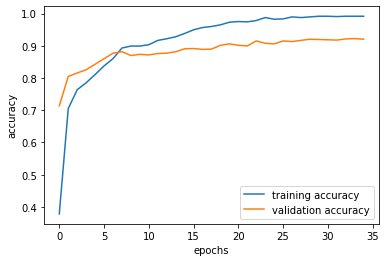

In [149]:
plot_accuracy(history_00)

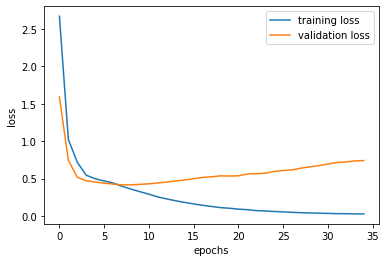

In [150]:
plot_loss(history_00)

<AxesSubplot:>

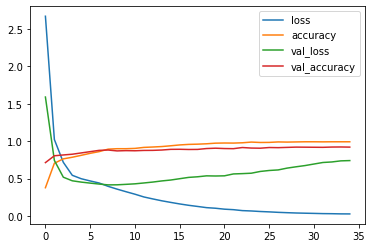

In [151]:
pd.DataFrame(history_00.history).plot()

In [132]:
# model 0a: relu / tanh

In [133]:
# model 0a
# Clear session and build above model:
K.clear_session()
model_0a = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(3,activation= 'softmax')   
])

In [134]:
# Check the summary:
model_0a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [135]:
# compile model
model_0a.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [136]:
# fit the model
history_0a = model_0a.fit(X_train,y_train,batch_size=722,epochs=40,validation_data=(X_val,y_val),)

Epoch 1/40
2/2 [==============================] - 25s 6s/step - loss: 1.1611 - accuracy: 0.3772 - val_loss: 0.7365 - val_accuracy: 0.6947
Epoch 2/40
2/2 [==============================] - 13s 5s/step - loss: 0.6988 - accuracy: 0.7348 - val_loss: 0.5582 - val_accuracy: 0.7832
Epoch 3/40
2/2 [==============================] - 14s 6s/step - loss: 0.4790 - accuracy: 0.8150 - val_loss: 0.4642 - val_accuracy: 0.8500
Epoch 4/40
2/2 [==============================] - 11s 5s/step - loss: 0.3771 - accuracy: 0.8828 - val_loss: 0.2622 - val_accuracy: 0.9079
Epoch 5/40
2/2 [==============================] - 11s 5s/step - loss: 0.2820 - accuracy: 0.9013 - val_loss: 0.2322 - val_accuracy: 0.9133
Epoch 6/40
2/2 [==============================] - 11s 5s/step - loss: 0.2350 - accuracy: 0.9157 - val_loss: 0.2060 - val_accuracy: 0.9196
Epoch 7/40
2/2 [==============================] - 11s 5s/step - loss: 0.1742 - accuracy: 0.9476 - val_loss: 0.1957 - val_accuracy: 0.9277
Epoch 8/40
2/2 [==================

In [157]:
model_0a.save('../data/models/three_instruments/2conv_0a.h5')

In [137]:
# examine the model

In [138]:
history_0a.history;

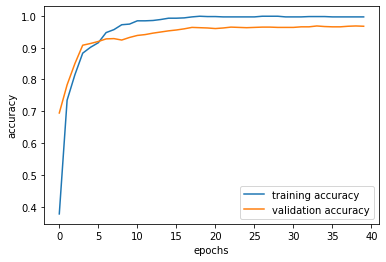

In [139]:
plot_accuracy(history_0a)

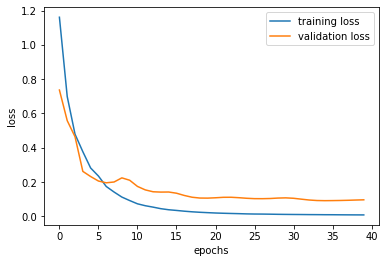

In [140]:
plot_loss(history_0a)

<AxesSubplot:>

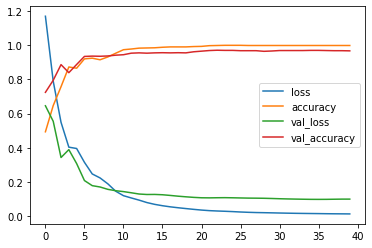

In [162]:
pd.DataFrame(history_0a.history).plot()

In [2]:
import os
import librosa
import librosa.display
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pickle

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#### The Medley Instruments Data Set

In [4]:
df = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata.csv')

In [5]:
df

,subset,instrument,instrument_id,song_id,uuid4
0,test,clarinet,0,0,0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3
1,test,clarinet,0,0,33383119-fd64-59c1-f596-d1a23e8a0eff
2,test,clarinet,0,0,b2b7a288-e169-5642-fced-b509c06b11fc
3,test,clarinet,0,0,151b6ee4-313a-58d9-fbcb-bab73e0d426b
4,test,clarinet,0,0,b43999d1-9b5e-557f-f9bc-1b3759659858
...,...,...,...,...,...
21566,validation,violin,7,226,fe4e8e98-6e0f-5a31-f446-99c10e0ac485
21567,validation,violin,7,226,aa606c78-9ee5-507f-f7e9-67c3530faf0f
21568,validation,violin,7,226,05e15c0a-d530-5f3e-fa82-58c55fa44993
21569,validation,violin,7,226,2dd485de-471d-5d8b-fe92-ef957dac021c


In [6]:
df.nunique()

subset               3
instrument           8
instrument_id        8
song_id            227
uuid4            21571
dtype: int64

In [7]:
df['instrument'].unique()

array(['clarinet', 'distorted electric guitar', 'female singer', 'flute',
       'piano', 'tenor saxophone', 'trumpet', 'violin'], dtype=object)

In [8]:
df.groupby(['instrument']).count()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1311,1311,1311,1311
distorted electric guitar,1854,1854,1854,1854
female singer,1744,1744,1744,1744
flute,3555,3555,3555,3555
piano,6032,6032,6032,6032
tenor saxophone,477,477,477,477
trumpet,627,627,627,627
violin,5971,5971,5971,5971


In [9]:
df.groupby(['instrument']).count().sum()

subset           21571
instrument_id    21571
song_id          21571
uuid4            21571
dtype: int64

In [10]:
df['subset'].unique()

array(['test', 'training', 'validation'], dtype=object)

In [11]:
df.groupby(['subset']).count()

,instrument,instrument_id,song_id,uuid4
subset,,,,
test,12236,12236,12236,12236
training,5841,5841,5841,5841
validation,3494,3494,3494,3494


Splitting Dataframe into Train, Validation and Test Dataframes

In [12]:
df_train = df.loc[df['subset']=='training']

##### Read train, validation and test dataframes

In [13]:
df_train = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_training.csv',index_col=0)

In [14]:
df_val = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_validation.csv',index_col=0)

In [15]:
df_test = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_test.csv',index_col=0)

In [16]:
df_train.head()

,subset,instrument,instrument_id,song_id,uuid4
12236,training,clarinet,0,139,163fd2b1-8e98-515a-f501-4742cc6d066f
12237,training,clarinet,0,139,36dcb8eb-da46-5d01-fa9d-0f715c389379
12238,training,clarinet,0,139,9f6d4046-3662-5433-fc44-98c80a428fd8
12239,training,clarinet,0,139,5ef6a0ee-a092-5d49-f64e-a3454e9ab237
12240,training,clarinet,0,139,2048e98b-77b2-5b7d-fe6a-780f399e69fe


#### First  approach: model for two instruments

In [17]:
# processing approach:
# define dataframe_subset_instrument
# load into librosa .wav to audio array (n,)
# save arrays with numpy

In [18]:
# starting with the Train Set: 404 elements distorted guitar

In [19]:
# begin with two instruments

In [20]:
instruments = df_train['instrument'].unique()

In [21]:
df_train.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,5,251
distorted electric guitar,1,1,10,404
female singer,1,1,7,318
flute,1,1,3,155
piano,1,1,20,2401
tenor saxophone,1,1,2,123
trumpet,1,1,4,149
violin,1,1,10,2040


In [22]:
df_val.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,2,328
distorted electric guitar,1,1,4,495
female singer,1,1,4,284
flute,1,1,2,233
piano,1,1,8,1022
tenor saxophone,1,1,1,29
trumpet,1,1,2,72
violin,1,1,4,1031


In [23]:
df_test.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,18,732
distorted electric guitar,1,1,11,955
female singer,1,1,12,1142
flute,1,1,29,3167
piano,1,1,15,2609
tenor saxophone,1,1,5,325
trumpet,1,1,27,406
violin,1,1,22,2900


Understanding how the data: how many songs were used per class

In [24]:
df_train.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                             [139, 140, 141, 142, 143]
distorted electric guitar    [144, 145, 146, 147, 148, 149, 150, 151, 152, ...
female singer                              [154, 155, 156, 157, 158, 159, 160]
flute                                                          [161, 162, 163]
piano                        [164, 165, 166, 167, 168, 169, 170, 171, 172, ...
tenor saxophone                                                     [184, 185]
trumpet                                                   [186, 187, 188, 189]
violin                       [190, 191, 192, 193, 194, 195, 196, 197, 198, ...
Name: song_id, dtype: object

In [25]:
df_val.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                                   [200, 201]
distorted electric guitar                        [202, 203, 204, 205]
female singer                                    [206, 207, 208, 209]
flute                                                      [210, 211]
piano                        [212, 213, 214, 215, 216, 217, 218, 219]
tenor saxophone                                                 [220]
trumpet                                                    [221, 222]
violin                                           [223, 224, 225, 226]
Name: song_id, dtype: object

In [26]:
df_val.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                                   [200, 201]
distorted electric guitar                        [202, 203, 204, 205]
female singer                                    [206, 207, 208, 209]
flute                                                      [210, 211]
piano                        [212, 213, 214, 215, 216, 217, 218, 219]
tenor saxophone                                                 [220]
trumpet                                                    [221, 222]
violin                                           [223, 224, 225, 226]
Name: song_id, dtype: object

In [27]:
# smaller data frames

In [28]:
df_train_clarinet = df_train.loc[df_train['instrument_id']==0].set_index('subset').reset_index()

In [29]:
df_train_guitar = df_train.loc[df_train['instrument_id']==1].set_index('subset').reset_index()

In [30]:
df_train_singer = df_train.loc[df_train['instrument_id']==2].set_index('subset').reset_index()

In [31]:
df_train_singer.head(3)

,subset,instrument,instrument_id,song_id,uuid4
0,training,female singer,2,154,5fe4c1de-b6da-5b50-f4d6-ed9925fc0931
1,training,female singer,2,154,69cbbcff-834b-55c0-f7fe-4d809ebe34e3
2,training,female singer,2,154,94072b83-a4ae-57a9-f196-a74af1e5f3b0


In [32]:
df_train_guitar.shape

(404, 5)

In [33]:
df_train_singer.shape

(318, 5)

In [34]:
# with the validation subset

In [35]:
df_val_clarinet = df_val.loc[df_val['instrument_id']==0].set_index('subset').reset_index()

In [36]:
df_val_guitar = df_val.loc[df_val['instrument_id']==1].set_index('subset').reset_index()

In [37]:
df_val_singer = df_val.loc[df_val['instrument_id']==2].set_index('subset').reset_index()

In [38]:
# with the test subset

In [39]:
df_test_clarinet = df_test.loc[df_test['instrument_id']==0].set_index('subset').reset_index()

In [40]:
df_test_guitar = df_test.loc[df_test['instrument_id']==1].set_index('subset').reset_index()

In [41]:
df_test_singer = df_test.loc[df_test['instrument_id']==2].set_index('subset').reset_index()

#### Loading signal saved in .npy numpy array files

In [42]:
filename_pre = "Medley-solos-DB"

In [43]:
def load_amp_file(filename,df):
    """input: filename, for example: amp_tr_clarinet
    output: list of amplitude vectors
    """
    # load amplitude vector
    # the corresponding dataframe must be at hand
    n_elements=(len(df))
    folderpath="../../../../../../documents/data/audio/medley/audio_arrays/"
    amp_list=[]
    with open (folderpath+filename, 'rb') as f:
        for n in range(n_elements):
            amp_1 = np.load(f)
            amp_list.append(amp_1)
    return amp_list

In [44]:
amplitude_train_clarinet = load_amp_file('amp_tr_clarinet', df_train_clarinet)

In [45]:
amplitude_train_guitar = load_amp_file('amp_tr_guitar', df_train_guitar)

In [46]:
amplitude_train_singer = load_amp_file('amp_tr_singer', df_train_singer)

In [47]:
# it works!

In [48]:
# with the val dataframes

In [49]:
#load validation subset amplitude arrays

In [50]:
amplitude_val_clarinet = load_amp_file('amp_val_clarinet', df_val_clarinet)

In [51]:
amplitude_val_guitar = load_amp_file('amp_val_guitar', df_val_guitar)

In [52]:
amplitude_val_singer = load_amp_file('amp_val_singer', df_val_singer)

In [53]:
#with the test dataframes

In [54]:
#load test subset amplitude arrays

In [55]:
amplitude_test_clarinet = load_amp_file('amp_test_clarinet', df_test_clarinet)

In [56]:
amplitude_test_guitar = load_amp_file('amp_test_guitar', df_test_guitar)

In [57]:
amplitude_test_singer = load_amp_file('amp_test_singer', df_test_singer)

In [58]:
#benchmark

In [59]:
len(amplitude_train_clarinet), len(amplitude_train_guitar), len(amplitude_train_singer)

(251, 404, 318)

In [60]:
# correct!

In [61]:
len(amplitude_val_clarinet), len(amplitude_val_guitar), len(amplitude_val_singer)

(328, 495, 284)

In [62]:
# correct!

In [63]:
len(amplitude_test_clarinet), len(amplitude_test_guitar), len(amplitude_test_singer)

(732, 955, 1142)

In [64]:
# correct!

In [65]:
amplitude_test_clarinet[0].shape, amplitude_test_guitar[0].shape, amplitude_test_singer[0].shape

((65536,), (65536,), (65536,))

In [66]:
# it worked!

In [67]:
# up here: second part, load data and ML

MEL SPECTROGRAM

In [68]:
def amp_list_to_mel_list(amp_list):
    """input: list of signal arrays 1d
    output: list of melspectrogram arrays 2d"""
    mel_list=[]
    for amplitude_1 in amp_list:
        mel_spectrogram_1 = librosa.feature.melspectrogram(y=amplitude_1,n_mels=129)
        mel_list.append(mel_spectrogram_1)  
    return mel_list

In [69]:
## TRAINING SUBSET

In [70]:
mel_spectrogram_train_clarinet = amp_list_to_mel_list(amplitude_train_clarinet)

In [71]:
mel_spectrogram_train_guitar = amp_list_to_mel_list(amplitude_train_guitar)

In [72]:
mel_spectrogram_train_singer = amp_list_to_mel_list(amplitude_train_singer)

In [73]:
len(mel_spectrogram_train_clarinet), len(mel_spectrogram_train_guitar), len(mel_spectrogram_train_singer)

(251, 404, 318)

In [74]:
mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_singer[0].shape

((129, 129), (129, 129), (129, 129))

In [75]:
X_tr_clarinet = np.stack(mel_spectrogram_train_clarinet,axis=0)
X_tr_clarinet.shape

(251, 129, 129)

In [76]:
X_tr_clarinet_resh = X_tr_clarinet.reshape(251,129,129,1)

In [77]:
X_tr_clarinet_resh.shape

(251, 129, 129, 1)

In [78]:
y_tr_clarinet = np.zeros((251,1))

In [79]:
X_tr_guitar = np.stack(mel_spectrogram_train_guitar,axis=0)
X_tr_guitar.shape

(404, 129, 129)

In [80]:
X_tr_guitar_resh = X_tr_guitar.reshape(404,129,129,1)

In [81]:
y_tr_guitar = np.ones((404,1))

In [82]:
X_tr_singer = np.stack(mel_spectrogram_train_singer,axis=0)
X_tr_singer.shape

(318, 129, 129)

In [83]:
X_tr_singer_resh = X_tr_singer.reshape(318,129,129,-1)

In [84]:
X_tr_singer_resh.shape

(318, 129, 129, 1)

In [85]:
y_tr_singer = np.ones((318,1))*2

In [86]:
# X_train shape (number wav files, f domain, t domain, 1)
# number wav clarinet + guitar + singer:
(251 + 404 + 318, 722, 90, 129)

(973, 722, 90, 129)

In [87]:
X_train = np.concatenate([X_tr_clarinet_resh, X_tr_guitar_resh, X_tr_singer_resh])

In [88]:
X_train.shape

(973, 129, 129, 1)

In [89]:
y_train = np.concatenate([y_tr_clarinet, y_tr_guitar, y_tr_singer])

In [90]:
y_train.shape

(973, 1)

In [91]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_train_true = y_train.copy()

In [92]:
y_train = to_categorical(y_train)

In [93]:
y_train.shape

(973, 3)

In [94]:
## VALIDATION SUBSET

In [95]:
mel_spectrogram_val_clarinet = amp_list_to_mel_list(amplitude_val_clarinet)

In [96]:
mel_spectrogram_val_guitar = amp_list_to_mel_list(amplitude_val_guitar)

In [97]:
mel_spectrogram_val_singer = amp_list_to_mel_list(amplitude_val_singer)

In [98]:
len(mel_spectrogram_val_clarinet), len(mel_spectrogram_val_guitar), len(mel_spectrogram_val_singer)

(328, 495, 284)

In [99]:
mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_singer[0].shape

((129, 129), (129, 129), (129, 129))

In [100]:
# X_val, y val

In [101]:
# clarinet

In [102]:
X_val_clarinet = np.stack(mel_spectrogram_val_clarinet,axis=0)
X_val_clarinet.shape

(328, 129, 129)

In [103]:
X_val_clarinet_resh = X_val_clarinet.reshape(328,129,129,1)

In [104]:
X_val_clarinet_resh.shape

(328, 129, 129, 1)

In [105]:
y_val_clarinet = np.zeros((328,1))

In [106]:
# guitar

In [107]:
X_val_guitar = np.stack(mel_spectrogram_val_guitar,axis=0)
X_val_guitar.shape

(495, 129, 129)

In [108]:
X_val_guitar_resh = X_val_guitar.reshape(495,129,129,1)

In [109]:
X_val_guitar_resh.shape

(495, 129, 129, 1)

In [110]:
y_val_guitar = np.ones((495,1))

In [111]:
# singer

In [112]:
X_val_singer = np.stack(mel_spectrogram_val_singer,axis=0)
X_val_singer.shape

(284, 129, 129)

In [113]:
X_val_singer_resh = X_val_singer.reshape(284,129,129,-1)

In [114]:
X_val_singer_resh.shape

(284, 129, 129, 1)

In [115]:
y_val_singer = np.ones((284,1))*2

In [116]:
# X_val shape (number wav files, f domain, t domain, 1)
# number wav guitar + singer:
(328 + 495 + 284, 90, 129)

(1107, 90, 129)

In [117]:
X_val = np.concatenate([X_val_clarinet_resh, X_val_guitar_resh, X_val_singer_resh])

In [118]:
X_val.shape

(1107, 129, 129, 1)

In [119]:
y_val = np.concatenate([y_val_clarinet, y_val_guitar, y_val_singer])

In [120]:
y_val_clarinet[327][0]

0.0

In [124]:
y_val_guitar[494][0]

1.0

In [125]:
y_val_singer[283][0]

2.0

In [126]:
y_val.shape

(1107, 1)

In [127]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_val_true = y_val.copy()

In [128]:
y_val = to_categorical(y_val)

In [129]:
y_val.shape

(1107, 3)

In [130]:
y_val

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [131]:
# the same needs to be done with the test 

MODELLING

In [132]:
# general functions and plots

In [133]:
def plot_accuracy(history):    
    # Plot accuracy curve
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()

In [134]:
def plot_loss(history):
# Plot loss
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

In [135]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'
)

In [136]:
# Model

In [137]:
#model 00: relu, relu

In [138]:
# model 00
# Clear session and build above model:
K.clear_session()
model_00 = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(3,activation= 'softmax')   
])

In [139]:
# Check the summary:
model_00.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [140]:
# compile model
model_00.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [141]:
X_train.shape, y_train.shape

((973, 129, 129, 1), (973, 3))

In [142]:
X_val.shape, y_val.shape

((1107, 129, 129, 1), (1107, 3))

In [143]:
# fit the model
history_00 = model_00.fit(X_train,y_train,batch_size=400, epochs=35,validation_data=(X_val,y_val))

Epoch 1/35
3/3 [==============================] - 16s 4s/step - loss: 2.6685 - accuracy: 0.3782 - val_loss: 1.5894 - val_accuracy: 0.7136
Epoch 2/35
3/3 [==============================] - 10s 3s/step - loss: 1.0218 - accuracy: 0.7050 - val_loss: 0.7428 - val_accuracy: 0.8049
Epoch 3/35
3/3 [==============================] - 10s 3s/step - loss: 0.7171 - accuracy: 0.7636 - val_loss: 0.5187 - val_accuracy: 0.8157
Epoch 4/35
3/3 [==============================] - 10s 3s/step - loss: 0.5442 - accuracy: 0.7852 - val_loss: 0.4707 - val_accuracy: 0.8257
Epoch 5/35
3/3 [==============================] - 11s 4s/step - loss: 0.4983 - accuracy: 0.8109 - val_loss: 0.4532 - val_accuracy: 0.8428
Epoch 6/35
3/3 [==============================] - 11s 4s/step - loss: 0.4685 - accuracy: 0.8376 - val_loss: 0.4397 - val_accuracy: 0.8600
Epoch 7/35
3/3 [==============================] - 10s 3s/step - loss: 0.4412 - accuracy: 0.8602 - val_loss: 0.4271 - val_accuracy: 0.8771
Epoch 8/35
3/3 [==================

In [144]:
model_00.save('../data/models/three_instruments/2conv_00.h5')

In [145]:
with open('../data/models/three_instruments/2conv_00_hist.h5', 'wb') as file_pi:
    pickle.dump(history_00.history, file_pi)

In [146]:
# history_2B_loaded = pickle.load(open('../data/models/two_instruments/3conv2d_bn_dout_hist.h5',"rb"))

In [147]:
# examine the model

In [148]:
history_00.history;

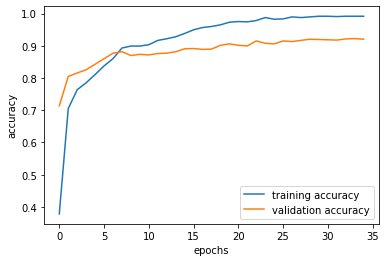

In [149]:
plot_accuracy(history_00)

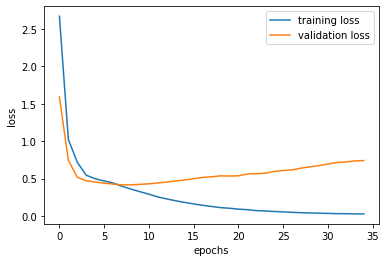

In [150]:
plot_loss(history_00)

<AxesSubplot:>

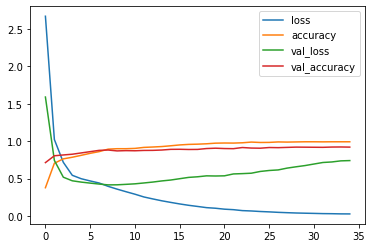

In [151]:
pd.DataFrame(history_00.history).plot()

In [152]:
# model 0a: relu / tanh

In [153]:
# model 0a
# Clear session and build above model:
K.clear_session()
model_0a = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(3,activation= 'softmax')   
])

In [154]:
# Check the summary:
model_0a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [155]:
# compile model
model_0a.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [156]:
# fit the model
history_0a = model_0a.fit(X_train,y_train,batch_size=722,epochs=40,validation_data=(X_val,y_val),)

Epoch 1/40
2/2 [==============================] - 12s 5s/step - loss: 1.1676 - accuracy: 0.4933 - val_loss: 0.6452 - val_accuracy: 0.7236
Epoch 2/40
2/2 [==============================] - 10s 4s/step - loss: 0.7885 - accuracy: 0.6465 - val_loss: 0.5546 - val_accuracy: 0.7940
Epoch 3/40
2/2 [==============================] - 10s 4s/step - loss: 0.5486 - accuracy: 0.7564 - val_loss: 0.3432 - val_accuracy: 0.8853
Epoch 4/40
2/2 [==============================] - 11s 5s/step - loss: 0.4036 - accuracy: 0.8715 - val_loss: 0.3892 - val_accuracy: 0.8383
Epoch 5/40
2/2 [==============================] - 11s 5s/step - loss: 0.3958 - accuracy: 0.8643 - val_loss: 0.3079 - val_accuracy: 0.8862
Epoch 6/40
2/2 [==============================] - 10s 4s/step - loss: 0.3152 - accuracy: 0.9188 - val_loss: 0.2088 - val_accuracy: 0.9332
Epoch 7/40
2/2 [==============================] - 10s 5s/step - loss: 0.2473 - accuracy: 0.9229 - val_loss: 0.1790 - val_accuracy: 0.9350
Epoch 8/40
2/2 [==================

In [157]:
model_0a.save('../data/models/three_instruments/2conv_0a.h5')

In [158]:
# examine the model

In [159]:
history_0a.history;

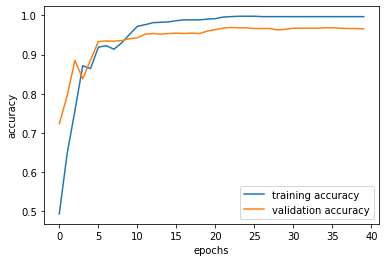

In [160]:
plot_accuracy(history_0a)

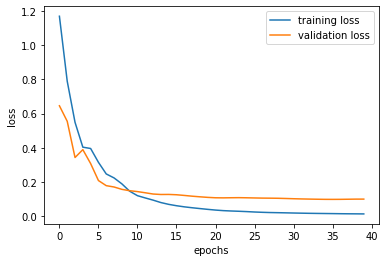

In [161]:
plot_loss(history_0a)

<AxesSubplot:>

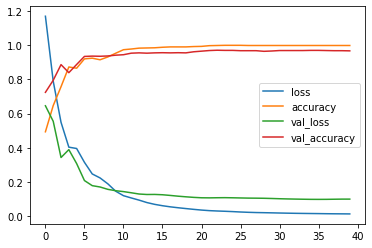

In [162]:
pd.DataFrame(history_0a.history).plot()